## Full MNIST dataset for digit image classification
Hard approach using low-level fast.ai and PyTorch.

In [148]:
from fastai.vision.all import *

### Load training and validation data

In [149]:
path = untar_data(URLs.MNIST)

In [150]:
train_path = path/'training'
dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_items=get_image_files, 
                   splitter=RandomSplitter(0.2, seed=None),
                   get_y=parent_label)
dls = dblock.dataloaders(train_path, bs=64)

In [151]:
dls.vocab, len(dls.vocab)

(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], 10)

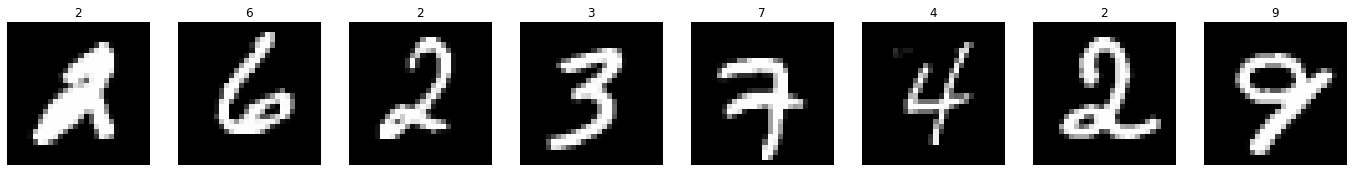

In [152]:
dls.show_batch(max_n=8, nrows=1)

In [153]:
dblock.summary(train_path)

Setting-up type transforms pipelines
Found 60000 items
2 datasets of sizes 48000,12000
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /home/mikes/.fastai/data/mnist_png/training/8/24150.png
    applying PILBase.create gives
      PILImage mode=RGB size=28x28
  Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /home/mikes/.fastai/data/mnist_png/training/8/24150.png
    applying parent_label gives
      8
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(8)

Final sample: (PILImage mode=RGB size=28x28, TensorCategory(8))


Found 60000 items
2 datasets of sizes 48000,12000
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
Setting up after_i

### Prepare test data

In [154]:
a5 = PILImage.create((path/'testing'/'5').ls()[0])
a5

In [155]:
a7 = PILImage.create((path/'testing'/'7').ls()[0])
a7

### Train model

In [156]:
image_size = 28*28*3

In [157]:
def image_category_loss(predictions, targets):
    predictions = predictions.log_softmax(dim=1)
    # return (-predictions[range(predictions.shape[0]), targets]).mean()
    return F.nll_loss(predictions, targets)

In [158]:
def batch_accuracy(predictions, targets):
    predictions = predictions.softmax(dim=1)
    correct = torch.argmax(predictions, dim=1) == targets
    return correct.float().mean()

In [159]:
def validate_epoch(model, dl):
    losses = [image_category_loss(model(xb.view(xb.shape[0], -1)), yb) for xb,yb in dl]
    accuracies = [batch_accuracy(model(xb.view(xb.shape[0], -1)), yb) for xb,yb in dl]
    return torch.stack(losses).mean().item(), torch.stack(accuracies).mean().item()

In [160]:
def train_epoch(model, dl, lr):
    for xb,yb in dl:
        predictions = model(xb.view(xb.shape[0], -1))
        loss = image_category_loss(predictions, yb)
        loss.backward()
        for p in model.parameters():
            p.data -= p.grad*lr
            p.grad.zero_()
    return loss.item()

In [161]:
def train_model(dls, model, epochs, lr):
    for epoch in range(epochs):
        loss = train_epoch(model, dls.train, lr)
        valid_loss, accuracy = validate_epoch(model, dls.valid)
        print(f"epoch {epoch:2d}: train_loss={loss:8f} valid_loss={valid_loss:8f} accuracy={accuracy:8f}")

In [162]:
def classify_digit(digit):
    digit_tensor = IntToFloatTensor(div=255.0, div_mask=1)(ToTensor()(digit)).to(default_device())
    predictions = model(digit_tensor.reshape(-1)).squeeze().softmax(dim=0)
    val, idx = torch.max(predictions, dim=0)
    return idx.item(), val.item()

In [163]:
model = nn.Sequential(
    nn.Linear(image_size, 100),
    nn.ReLU(),
    nn.Linear(100, len(dls.vocab))
).to(default_device())

In [164]:
train_model(dls, model, epochs=10, lr=0.1)

epoch  0: train_loss=0.227852 valid_loss=0.250517 accuracy=0.925116
epoch  1: train_loss=0.171338 valid_loss=0.171872 accuracy=0.949136
epoch  2: train_loss=0.073561 valid_loss=0.143074 accuracy=0.957197
epoch  3: train_loss=0.070316 valid_loss=0.122785 accuracy=0.963597
epoch  4: train_loss=0.120748 valid_loss=0.114255 accuracy=0.965758
epoch  5: train_loss=0.075735 valid_loss=0.104858 accuracy=0.968916
epoch  6: train_loss=0.099645 valid_loss=0.103913 accuracy=0.968002
epoch  7: train_loss=0.034342 valid_loss=0.096538 accuracy=0.969997
epoch  8: train_loss=0.019497 valid_loss=0.094305 accuracy=0.970828
epoch  9: train_loss=0.013296 valid_loss=0.089128 accuracy=0.972739


### Test model

In [165]:
classify_digit(a5)

(5, 0.9941278696060181)

In [166]:
classify_digit(a7)

(7, 0.9999872446060181)